LSTM Dynamical Systems Reconstruction
=======

Reconstruction of Lorenz System
---------

Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import matplotlib.gridspec as gridspec

Loading the raw data

In [2]:
lorenz_train=np.load("data/lorenz_train.npy")
lorenz_test=np.load("data/lorenz_test.npy")
print("Train data size: ",lorenz_train.shape)
print("Test data size: ",lorenz_test.shape)

Train data size:  (100, 1000, 3)
Test data size:  (100, 1000, 3)


Hyperparameters

In [3]:
torch.manual_seed(42)

hidden_size = 20  # number of hidden units x RNN
input_size = len(lorenz_train[0,0,:])  # number of input units
output_size = len(lorenz_train[0,0,:])  # number of output units
num_layers = 1  # number of layers
num_epochs = 2001  # number of times the network is trained
batch_size = len(lorenz_train[:,0,0])  # size of the input data used for one iteration
stretch_length = len(lorenz_train[0,:,0])  # length of the interval I use to build mini-batches
learning_rate = 0.01  # speed of convergence
recon_steps=np.array([1,2,4,6,8,10,20,50,100,500,1000,2000]) #epoch steps where reconstruction image should be saved

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.cuda.get_device_name(0))

Using cuda device
NVIDIA GeForce GTX 1070


Preparing input (X) and output (Y) data

In [4]:
def data_preperation(data): # function which prepares data
    t=np.arange(0,len(data[0,:,0]))
    X=torch.from_numpy(data[:,0:-1,:]).float().to(device)
    Y=torch.from_numpy(data[:,1:,:]).float().to(device)  # The output Y is n-steps ahead to the input, where n is the prediction length
    return X,Y,t

In [5]:
X_train,Y_train,t = data_preperation(lorenz_train)
X_test,Y_test,t = data_preperation(lorenz_test)

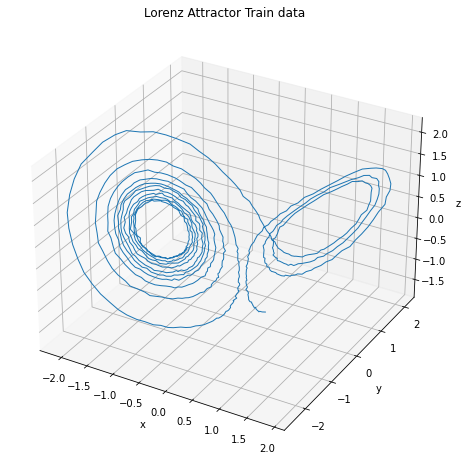

In [6]:
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d')
ax.plot(X_train[0,:,0].cpu().numpy(), X_train[0,:,1].cpu().numpy(), X_train[0,:,2].cpu().numpy(),linestyle='-', lw=1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Lorenz Attractor Train data")
plt.show()

Network structure

In [7]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MyRNN, self).__init__()  # Inherited from the parent class nn.Module
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True) # LSTM layer
        self.linear = nn.Linear(self.hidden_size, self.output_size)  # Define the output layer

    def forward(self, x):  # Forward pass: put each layer together

        output, hidden = self.lstm(x)
        output = self.linear(output)

        return output

Training
-------

Training function

In [8]:
def training(criterion, optimizer, model, num_epochs, batch_size, stretch_length,recon_steps):
    hist = np.zeros(num_epochs)
    recon_train = []
    recon_pred = []

    for t in range(num_epochs):

        y_pred = model(X_train) # Forward pass
        loss = criterion(y_pred, Y_train)  # Compute the loss: difference between the output and the pre-given solution
        hist[t] = loss.item()


        if t % 100 == 0: # Print loss every 100th epoch
            print("Epoch ", t, "MSE: ", loss.item())


        if t in recon_steps: # Store reconstruction
            OT = y_pred.detach().cpu().numpy()
            TG = Y_train.detach().cpu().numpy()
            recon_train.append(TG[0, :, :])
            recon_pred.append(OT[0, :, :])

        optimizer.zero_grad()
        loss.backward() # Backward Process
        optimizer.step()

    model_parameters = list(model.parameters())
    return model_parameters, model, hist, recon_train, recon_pred

Training of the network. In this setup the network gets trained to predict one timestep further.

In [9]:
# initialize the network based on parameters:
model = MyRNN(input_size, hidden_size, output_size, num_layers).to(device)

# compute the number of parameters to be trained
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('This model has ' + str(pytorch_total_params) + ' parameters to be trained')

# choosing loss function
criterion = nn.MSELoss()  # calculates a loss fct per minibatch based on Mean Squared Error
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adaptive moment estimation

#Training
NetParameters, model, hist, recon_train, recon_pred = training(criterion, optimizer, model, num_epochs, batch_size, stretch_length,recon_steps)

This model has 2063 parameters to be trained
Epoch  0 MSE:  1.0213431119918823
Epoch  100 MSE:  0.0013516634935513139
Epoch  200 MSE:  0.0007499621133320034
Epoch  300 MSE:  0.0005985203897580504
Epoch  400 MSE:  0.0005192518001422286
Epoch  500 MSE:  0.00046470921370200813
Epoch  600 MSE:  0.0004229642800055444
Epoch  700 MSE:  0.00038924638647586107
Epoch  800 MSE:  0.00036112574161961675
Epoch  900 MSE:  0.00033717398764565587
Epoch  1000 MSE:  0.0003164704830851406
Epoch  1100 MSE:  0.0002983849262818694
Epoch  1200 MSE:  0.0002824650437105447
Epoch  1300 MSE:  0.0002683711936697364
Epoch  1400 MSE:  0.00025583826936781406
Epoch  1500 MSE:  0.0002446516591589898
Epoch  1600 MSE:  0.0002346322435187176
Epoch  1700 MSE:  0.00022562652884516865
Epoch  1800 MSE:  0.00021750215091742575
Epoch  1900 MSE:  0.00021011107310187072
Epoch  2000 MSE:  0.0002034231583820656


Training Results
-----

Loss

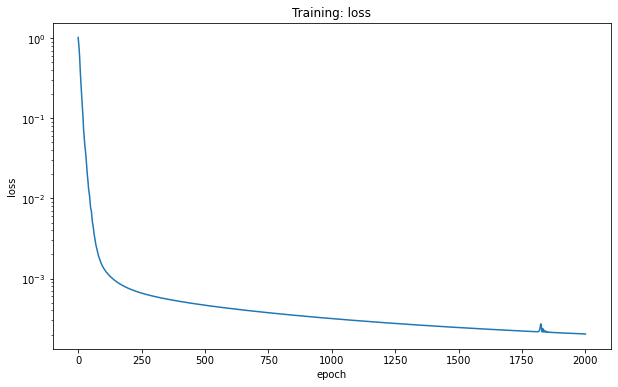

In [10]:
plt.figure(figsize=(10,6))

plt.plot(hist)
plt.title('Training: loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale("log")

Training reconstruction progress

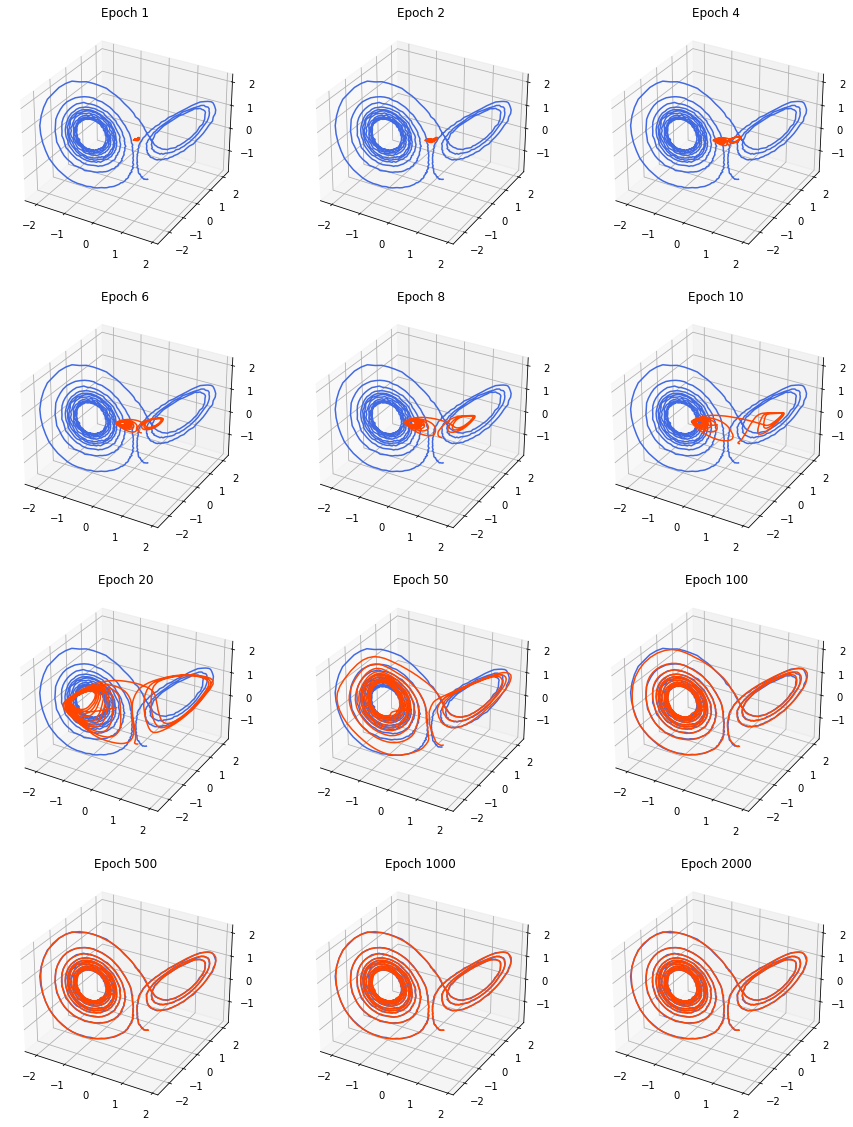

In [11]:
vert=round(np.sqrt(len(recon_train))) # Amount of vertical plots
hor=round(np.sqrt(len(recon_train))+0.5) # Amount of horizontal plots
fig = plt.figure(figsize=(vert*5,hor*5))

for i in range(vert):
    for j in range(min(hor,len(recon_train)-i*hor)):
        ax = fig.add_subplot(hor, vert, j+i*hor+1, projection='3d')
        ax.plot(recon_train[j+i*hor][:,0],recon_train[j+i*hor][:,1],recon_train[j+i*hor][:,2],label="data",color="royalblue") # plot training reconstruction data
        ax.plot(recon_pred[j+i*hor][:,0],recon_pred[j+i*hor][:,1],recon_pred[j+i*hor][:,2], label = "reconstruction",color="orangered") # Plot prediction
        ax.set_title("Epoch {}".format(recon_steps[j+i*hor]))

Testset Results
------

Calculate the predictions on the test set. For each timestep of X_test data one gets the prediction one timestep further. This gets compared with the true Y_test data.

In [12]:
# Calculate Prediction
y_pred = model(X_test)  # apply the trained model to training set

train_loss=hist[-1]
test_loss=criterion(y_pred,Y_test).item()
print("Training Loss: {:.8f}".format(round(train_loss,8)))
print("Testing Loss: {:.8f}".format(round(test_loss,8)))

y_pred = y_pred.cpu().detach().numpy()
y = Y_test.cpu().detach().numpy()

Training Loss: 0.00020342
Testing Loss: 0.00006573


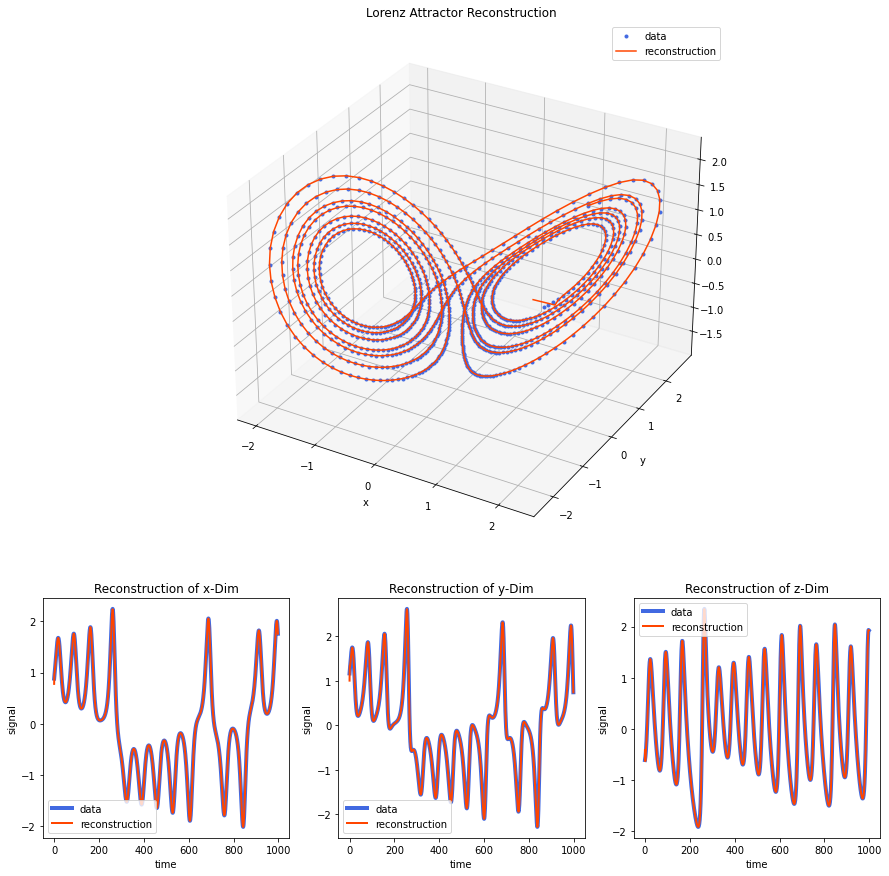

In [13]:
plt.figure(figsize=(15,15))
gridspec.GridSpec(3,3)

plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=2,projection='3d')
plt.plot(y[0,:,0],y[0,:,1],y[0,:,2],'.',label="data",color="royalblue")
plt.plot(y_pred[0,:,0],y_pred[0,:,1],y_pred[0,:,2],label="reconstruction",color="orangered")
plt.title("Lorenz Attractor Reconstruction")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.subplot2grid((3,3), (2,0))
plt.plot(y[0,:,0], label='data',color="royalblue",linewidth=4)
plt.plot(y_pred[0, :, 0], label='reconstruction',color="orangered",linewidth=2)
plt.legend()
plt.title('Reconstruction of x-Dim')
plt.xlabel('time')
plt.ylabel('signal')

plt.subplot2grid((3,3), (2,1))
plt.plot(y[0,:,1], label='data',color="royalblue",linewidth=4)
plt.plot(y_pred[0, :, 1], label='reconstruction',color="orangered",linewidth=2)
plt.legend()
plt.title('Reconstruction of y-Dim')
plt.xlabel('time')
plt.ylabel('signal')

plt.subplot2grid((3,3), (2,2))
plt.plot(y[0,:,2], label='data',color="royalblue",linewidth=4)
plt.plot(y_pred[0, :, 2], label='reconstruction',color="orangered",linewidth=2)
plt.legend()
plt.title('Reconstruction of z-Dim')
plt.xlabel('time')
plt.ylabel('signal')


plt.show()

N-Step ahead MSE
-------

For this calculation one inputs an initial point into the network and calculates the prediction after n-timepoints. This is done by appending the predicted point of the LSTM to the next input of the network n-times. 

The n-step ahead MSE is then calculated between the prediction and the true data (n-steps ahead)

In [14]:
def n_step_ahead_mse(num_traj,steps,n_steps,X_test,Y_test):
    traj_num=np.random.randint(len(X_test), size=num_traj) # draw random trajectory indicies from test set
    mse_n_step=np.zeros(steps)

    for j in traj_num:
        temp=[]
        ini=X_test[j,0:n_steps,:].reshape(1,n_steps,input_size)
        x=torch.ones(1,n_steps,input_size, dtype=torch.float).to(device)
        x=ini # initial inputs
        for i in range(steps):
            x = model(x)
            y=Y_test[j,i:n_steps+i,:].reshape(1,n_steps,input_size)
            y_pred=x[0,:,:].reshape(1,n_steps,input_size)

            loss=criterion(y_pred,y).item() #calculate loss
            temp.append(loss)
        temp=np.array(temp)
        mse_n_step+=temp
    return mse_n_step/num_traj

In [15]:
steps=500 # max n for the n-step ahead MSE
num_traj=50 # amount of different trajectorys which are used for calculation 
n_steps=200 # amount of points per trajectory which get compared for the MSE

mse_n_step_test=n_step_ahead_mse(num_traj,steps,n_steps,X_test,Y_test)

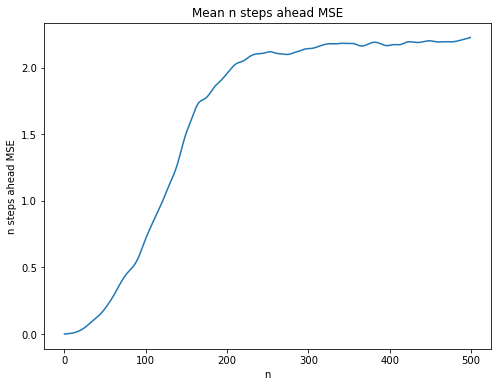

In [16]:
plt.figure(figsize=(8,6))
plt.plot(mse_n_step_test)
plt.xlabel("n")
plt.ylabel("n steps ahead MSE")
plt.title("Mean n steps ahead MSE")
plt.show()

Trajectory Prediction
--------

Using the one step ahead prediction of the LSTM again for input, one can construct the prediction for multiple timesteps ahead and therefore predict the trajectory from an initial point or sequence.

In [17]:
def traj_prediction(traj_num,steps,ini_steps,X_test,Y_test,n=100):  #Function which predicts the trajectory on the model
    ini=X_test[traj_num,n-ini_steps:n,:].reshape(1,ini_steps,input_size)
    x=torch.ones(1,ini_steps,input_size, dtype=torch.float).to(device)
    x=ini

    for j in range(steps): # Go over all future predictions

        y_pre = model(x)[:,-1,:].reshape(1,1,input_size) # get the predicted value which is one step ahead
        x=torch.cat((x,y_pre),axis=1) # Add the predicted value to the test set

    y=Y_test[traj_num,n:steps+n,:].reshape(1,steps,input_size)
    y_pred=x[0,ini_steps:ini_steps+steps,:].reshape(1,steps,input_size)
    loss=criterion(y_pred,y).item() # calculate loss

    return y.cpu().detach().numpy(),y_pred.cpu().detach().numpy(),ini.cpu().numpy(),loss

In [18]:
traj_num=0 # trajectory index in X_test which should get predicted
steps=400 # number of timesteps which schould get predicted (max 800)
ini_steps=100 # initial sequence length (max 100)

y,y_pred,x,loss=traj_prediction(traj_num,steps,ini_steps,X_test,Y_test)
print("MSE of predicted trajectory using a initial sequence: ",loss)
_,_,_,loss_single=traj_prediction(traj_num,steps,1,X_test,Y_test)
print("MSE of predicted trajectory using single initial point: ",loss_single)

MSE of predicted trajectory using a initial sequence:  0.005210054572671652
MSE of predicted trajectory using single initial point:  0.9653140306472778


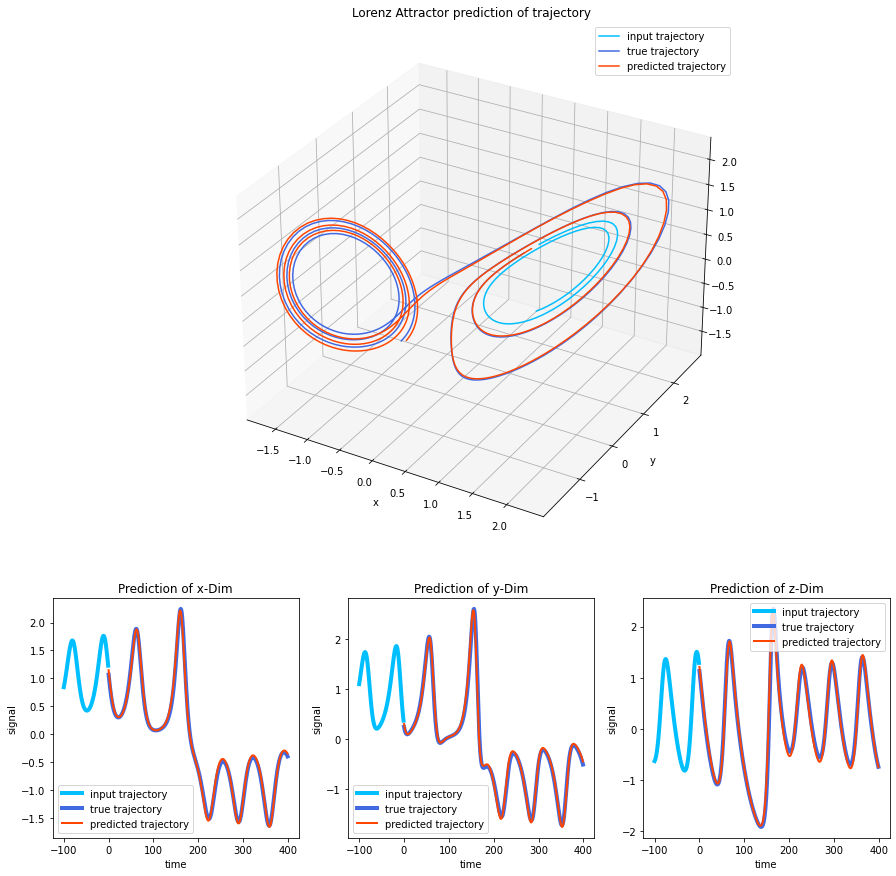

In [19]:
plt.figure(figsize=(15,15))
gridspec.GridSpec(3,3)

plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=2,projection='3d')
plt.plot(x[0,:,0],x[0,:,1],x[0,:,2],label="input trajectory",color="deepskyblue")
plt.plot(y[0,:,0],y[0,:,1],y[0,:,2],"-",label="true trajectory",color="royalblue")
plt.plot(y_pred[0,:,0],y_pred[0,:,1],y_pred[0,:,2],label="predicted trajectory",color="orangered")
plt.title("Lorenz Attractor prediction of trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.subplot2grid((3,3), (2,0))
plt.plot(np.arange(-len(x[0,:,0]),0),x[0,:,0], label='input trajectory',color="deepskyblue",linewidth=4)
plt.plot(np.arange(0,len(y[0,:,0])),y[0,:,0], label='true trajectory',color="royalblue",linewidth=4)
plt.plot(np.arange(0,len(y[0,:,0])),y_pred[0, :, 0], label='predicted trajectory',color="orangered",linewidth=2)
plt.legend()
plt.title('Prediction of x-Dim')
plt.xlabel('time')
plt.ylabel('signal')

plt.subplot2grid((3,3), (2,1))
plt.plot(np.arange(-len(x[0,:,0]),0),x[0,:,1], label='input trajectory',color="deepskyblue",linewidth=4)
plt.plot(np.arange(0,len(y[0,:,0])),y[0,:,1], label='true trajectory',color="royalblue",linewidth=4)
plt.plot(np.arange(0,len(y[0,:,0])),y_pred[0, :, 1], label='predicted trajectory',color="orangered",linewidth=2)
plt.legend()
plt.title('Prediction of y-Dim')
plt.xlabel('time')
plt.ylabel('signal')

plt.subplot2grid((3,3), (2,2))
plt.plot(np.arange(-len(x[0,:,0]),0),x[0,:,2], label='input trajectory',color="deepskyblue",linewidth=4)
plt.plot(np.arange(0,len(y[0,:,0])),y[0,:,2], label='true trajectory',color="royalblue",linewidth=4)
plt.plot(np.arange(0,len(y[0,:,0])),y_pred[0, :, 2], label='predicted trajectory',color="orangered",linewidth=2)
plt.legend()
plt.title('Prediction of z-Dim')
plt.xlabel('time')
plt.ylabel('signal')


plt.show()

Total MSE of the predicted trajetory according to the length of the input sequence

In [20]:
def sequence_length_mse(num_traj,steps,ini_steps,X_test,Y_test):
    mse=np.zeros(ini_steps)
    traj_num=np.random.randint(len(X_test), size=num_traj)

    for j in traj_num:
        temp=[]
        for i in np.arange(1,ini_steps+1):
            _,_,_,loss=traj_prediction(j,steps,i,X_test,Y_test)
            temp.append(loss)
        temp=np.array(temp)
        mse+=temp
    return mse/num_traj

In [21]:
steps=400
ini_steps=20
num_traj=20

mse=sequence_length_mse(num_traj,steps,ini_steps,X_test,Y_test)

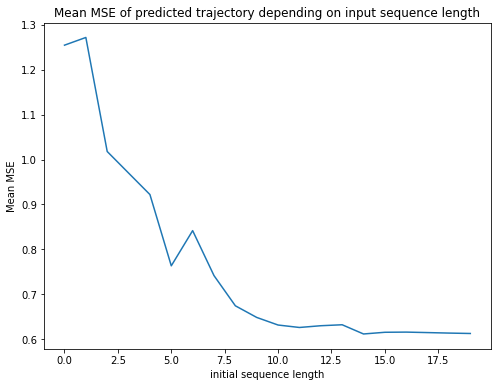

In [22]:
plt.figure(figsize=(8,6))
plt.plot(mse)
plt.xlabel("initial sequence length")
plt.ylabel("Mean MSE")
plt.title("Mean MSE of predicted trajectory depending on input sequence length")
plt.show()

Save/Load model
------

In [24]:
torch.save(model, 'model/LSTM_model_lorenz.pt') # save model

In [ ]:
model=torch.load('model/LSTM_model_lorenz.pt') # load model